# Diagnosing Heart Disease


# First, load the appropriate libraries,


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

# The Data

Next, load the data,

In [2]:
dt = pd.read_csv("../input/heart-disease/heart.csv")

Let's take a look,

In [3]:
dt.head(10)

age  sex  cp  trestbps  chol   ...    oldpeak  slope  ca  thal  target
0   63    1   3       145   233   ...        2.3      0   0     1       1
1   37    1   2       130   250   ...        3.5      0   0     2       1
2   41    0   1       130   204   ...        1.4      2   0     2       1
3   56    1   1       120   236   ...        0.8      2   0     2       1
4   57    0   0       120   354   ...        0.6      2   0     2       1
5   57    1   0       140   192   ...        0.4      1   0     1       1
6   56    0   1       140   294   ...        1.3      1   0     2       1
7   44    1   1       120   263   ...        0.0      2   0     3       1
8   52    1   2       172   199   ...        0.5      2   0     3       1
9   57    1   2       150   168   ...        1.6      2   0     2       1

[10 rows x 14 columns]

The meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

Let's change the column names to be a bit clearer,

In [4]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

Also changing the values of the categorical variables, to improve the interpretation later on,

In [5]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

Check the data types,

In [6]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

Some of those aren't quite right. The code below changes them into categorical variables,

In [7]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [8]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [9]:
dt = pd.get_dummies(dt, drop_first=True)

Now let's see,

In [10]:
dt.head()

age              ...                thalassemia_reversable defect
0   63              ...                                            0
1   37              ...                                            0
2   41              ...                                            0
3   56              ...                                            0
4   57              ...                                            0

[5 rows x 20 columns]

Looking good. Now, on to the model.

<a id='section3'></a>

# The Model

The next part fits a random forest model to the data,

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [12]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We can plot the consequent decision tree, to see what it's doing,

In [13]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [14]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

This gives us on explainability tool. However, I can't glance at this and get a quick sense of the most important features. We'll revisit those later. Next, let's evaluate the model,

# The Explanation

**Permutation importance** is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy.

In [15]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

So, it looks like the most important factors in terms of permutation is a thalessemia result of 'reversable defect'. The high importance of 'max heart rate achieved' type makes sense, as this is the immediate, subjective state of the patient at the time of examination (as opposed to, say, age, which is a much more general factor).

Let's take a closer look at the number of major vessles using a **Partial Dependence Plot**. These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect. Let's take a look at the 'num_major_vessels' variable, which was at the top of the permutation importance list,

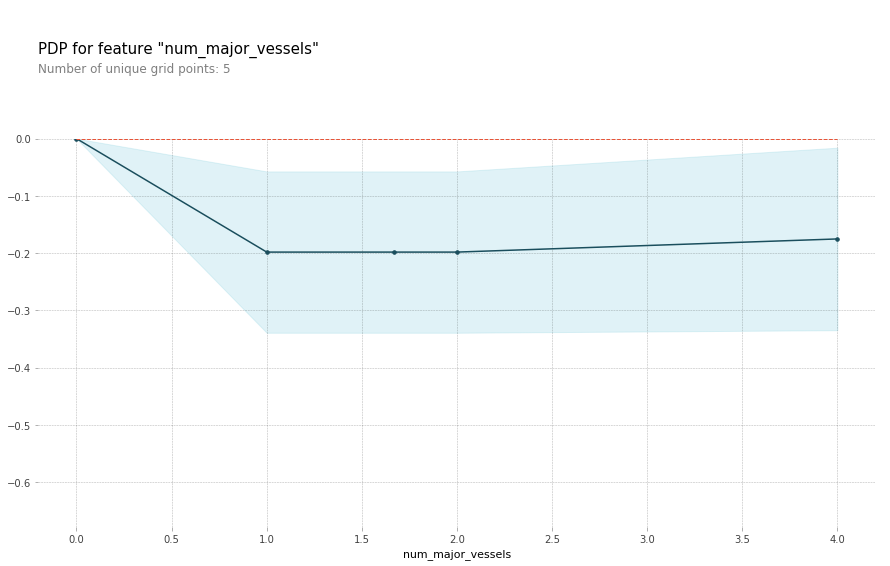

In [16]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the number of major blood vessels *increases*, the probability of heart disease *decreases*. That makes sense, as it means more blood can get to the heart.

What about the 'age',

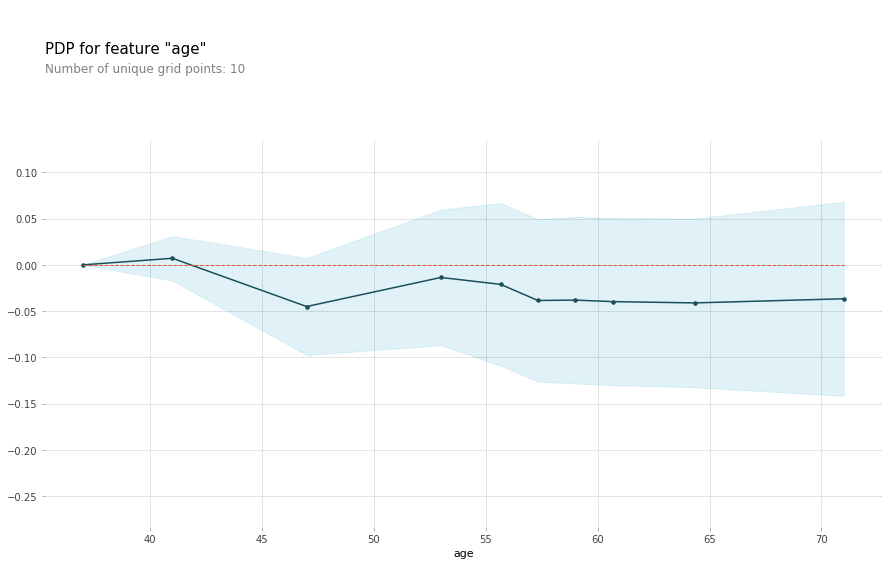

In [17]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

That's a bit odd. The higher the age, the lower the chance of heart disease? Althought the blue confidence regions show that this might not be true (the red baseline is within the blue zone).

What about the 'st_depression',

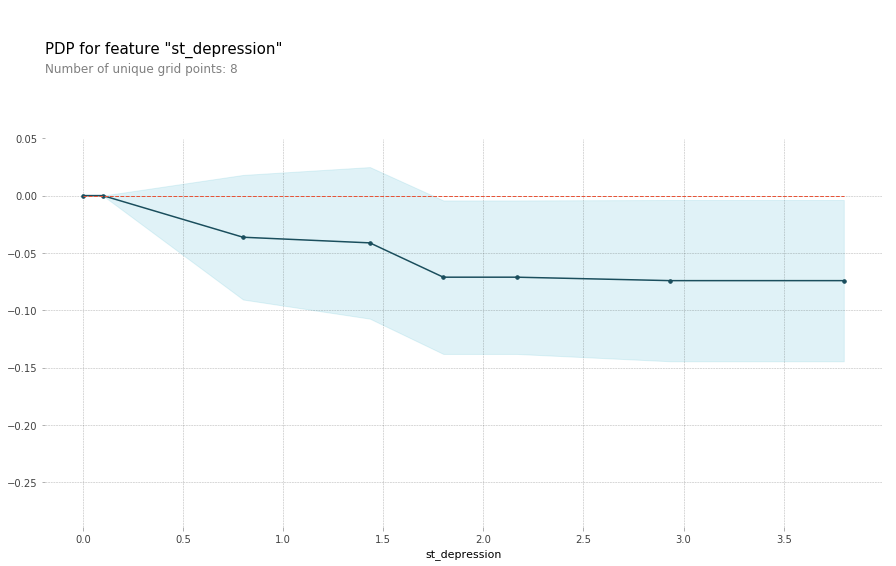

In [18]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Interestingly, this variable also shows a reduction in probability the higher it goes.The **ST segment** represents the heart's electrical activity immediately after the right and left ventricles have contracted, pumping blood to the lungs and the rest of the body. Following this big effort, ventricular muscle cells relax and get ready for the next contraction. During this period, little or no electricity is flowing, so the ST segment is even with the baseline or sometimes slightly above it. The faster the heart is beating during an ECG, the shorter all of the waves become. **The shape and direction of the ST segment are far more important than its length. Upward or downward shifts can represent decreased blood flow to the heart from a variety of causes, including heart attack, spasms in one or more coronary arteries (Prinzmetal's angina), infection of the lining of the heart (pericarditis) or the heart muscle itself (myocarditis), an excess of potassium in the bloodstream, a heart rhythm problem, or a blood clot in the lungs (pulmonary embolism)."***

<img style="float: left;" src="https://www.cvphysiology.com/uploads/images/CAD012%20ST%20elevation.png" width="350px"/>    [6](https://www.cvphysiology.com/CAD/CAD012)

So, this variable, which is described as 'ST depression induced by exercise relative to rest', seems to suggest the higher the value the higher the probability of heart disease.

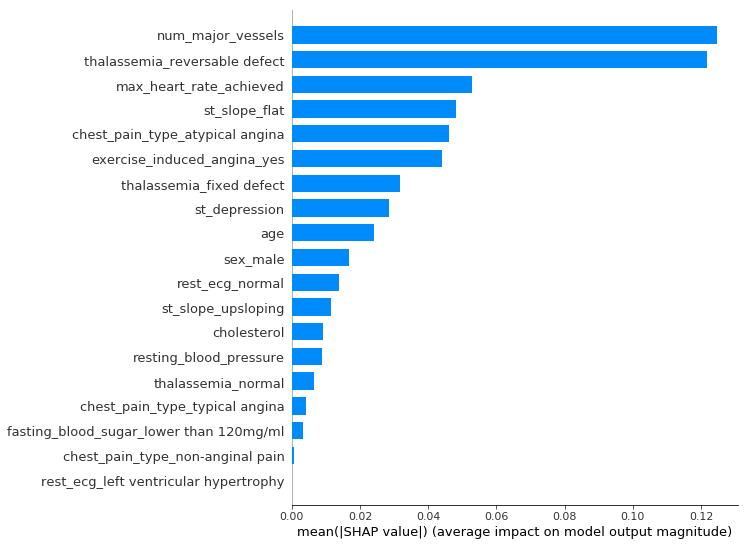

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

Next, let's pick out individual patients and see how the different variables are affecting their outcomes,

In [20]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [21]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [22]:
X_test.iloc[1,:]

age                                         58.0
resting_blood_pressure                     112.0
cholesterol                                230.0
max_heart_rate_achieved                    165.0
st_depression                                2.5
num_major_vessels                            1.0
sex_male                                     1.0
chest_pain_type_atypical angina              1.0
chest_pain_type_non-anginal pain             0.0
chest_pain_type_typical angina               0.0
fasting_blood_sugar_lower than 120mg/ml      1.0
rest_ecg_left ventricular hypertrophy        0.0
rest_ecg_normal                              1.0
exercise_induced_angina_yes                  0.0
st_slope_flat                                0.0
st_slope_upsloping                           1.0
thalassemia_fixed defect                     0.0
thalassemia_normal                           0.0
thalassemia_reversable defect                1.0
Name: 183, dtype: float64

For this person, their prediction is 36% (compared to a baseline of 58.4%). Many things are working in their favour, including having a major vessel, a reversible thalassemia defect, and *not* having a flat st_slope.

Let's check another,

In [23]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

For this person, their prediction is 70% (compared to a baseline of 58.4%). Not working in their favour are things like having no major vessels, a flat st_slope, and *not* a reversible thalassemia defect.

We can also plot something called 'SHAP dependence contribution plots' which are pretty self-explanatory in the context of SHAP values,

# The final plot is one of the most effective.
It shows the predictions and influencing factors for many (in this case 50) patients, all together. It's also interactive, which is great. Hover over to see *why* each person ended up either red (prediction of disease) or blue (prediction of no disease),

In [24]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

<a id='section5'></a>